In [3]:
import sys
import timeit
import cProfile
import calendar
import pandas as pd
import numpy as np
import datetime as dt
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta

In [126]:
next_month = start.month + 1 
next_date = dt.date(start.year,next_month,1)
days_in_month = (s2 - dt.timedelta(days=1)).day
print(days_in_month)
#s = somethign + relativedelta(day=-4)
#print(s)

30


In [4]:
code_to_test = """
def testing(start):
    next_month = start.month + 1 
    next_date = dt.date(start.year,next_month,1)
    days_in_month = (s2 - dt.timedelta(days=1)).day
    return days_in_month
"""

code_to_test2 = """
def testing(start):
    days = pd.to_datetime(start).days_in_month
    return days
"""

code_to_test3 = """
def testing(start):
    days = calendar.monthrange(start.year, start.month)[1]
    return days
"""

In [5]:
start = dt.date.fromisoformat("2023-11-05")

In [6]:
print(timeit.timeit(code_to_test,number=10000))

0.0007106560001375328


In [7]:
print(timeit.timeit(code_to_test2,number=10000))

0.0009646250000514556


In [8]:
print(timeit.timeit(code_to_test3,number=10000))

0.00088572300001033


In [2]:
sys.version

'3.10.10 (main, Feb  8 2023, 14:50:01) [GCC 9.4.0]'

In [40]:
%%time
def normalize_date(date,middle,when):
    days, months = None, 0
    match when:
            case "begin":
                days, months = 1, 1
                is_over = date > middle
            case "end":
                #next_month = (middle.month + 1) % 12
                #next_month = 1 if next_month == 0 else next_month
                #next_date = dt.date(middle.year,next_month,1)
                #days = (next_date - dt.timedelta(days=1)).day
                days = pd.to_datetime(middle).days_in_month
                is_over = date >= middle
    normalized = dt.date(date.year,date.month,days)+relativedelta(months=months) if is_over else date 
    return normalized

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 27.2 µs


In [31]:
%%time
def get_projection(thing, start, end, savings):
    projection = None
    match thing["frequency"]:
        case "weekly":
            projection = pd.date_range(start ,end ,freq=weekday_dicts[thing["when"]])
        case "daily":
            projection = pd.date_range(start ,end ,freq="d")
        case "monthly":
            middle =  end + relativedelta(day=thing["when"])
            real_end = normalize_date(end,middle,"end")
            middle_b = start + relativedelta(day=thing["when"])  
            real_start = normalize_date(start,middle_b,"begin")
            projection = [month + pd.DateOffset(day=thing["when"]) for month in pd.date_range(real_start,real_end,freq="M")]
    table = pd.DataFrame(index=projection)
    table[thing["name"]] = -thing["amount"] if thing["type"] == "expense" else thing["amount"]
    return table
    

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 20.3 µs


In [32]:
%%time
def get_expense_table(tables, savings):
    expense_table = pd.concat(tables, axis=1).fillna(0)
    columns = expense_table.columns.tolist()
    columns.insert(0, "savings")
    expense_table["savings"] =  expense_table.sum(axis=1).cumsum() + savings
    expense_table = expense_table.reindex(columns=columns)
    return expense_table

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.1 µs


In [45]:
#valid frequencies: yearly, monthly, weekly, daily
things = [
  { "name": "groceries", "amount": 10, "frequency": "daily", "when": np.nan,"type":"expense" },
  { "name": "cigarettes", "amount": 8.8, "frequency": "weekly", "when": "wednesday","type":"expense" },
  { "name": "salary", "amount": 2000, "frequency": "monthly", "when": 1,"type":"deposit" }
]
savings = 10000

weekday_dicts = {"monday":"w-mon","tuesday":"w-tue","wednesday":"w-wed","thursday":"w-thu",
                "friday":"w-fri","saturday":"w-sat"}

start, end = dt.date.fromisoformat("2023-11-05"), dt.date.fromisoformat("2023-12-02")

In [46]:
tables = [get_projection(thing, start, end, savings) for thing in things]

In [77]:
expense_tables = get_expense_table(tables,savings)

<Axes: >

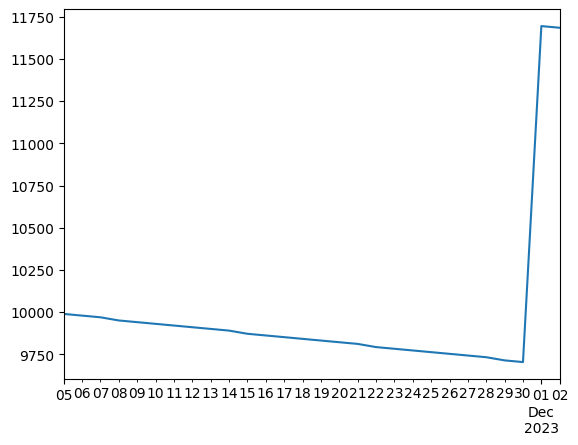

In [78]:
expense_tables.savings.plot()